In [1]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import voxelmorph as vxm
import neurite as ne

In [2]:
us = []
mri = []
for file_name in os.listdir("small_brains"):
  if "us" in file_name:
    data  = np.load("small_brains/" + file_name)
    us.append(data["image"])
    data = np.load("small_brains/" + file_name.replace("us", "mri"))
    mri.append(data["image"])
us = np.array(us[:5])
mri = np.array(mri[:5])

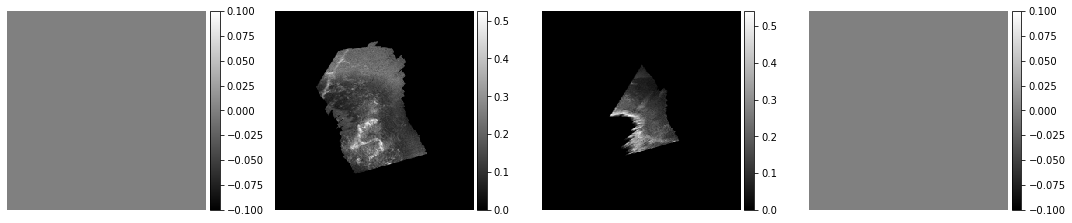

In [3]:
example_us = [us[0][1], us[0][15], us[0][20],us[0][30]]
ne.plot.slices(example_us, cmaps=['gray'], do_colorbars=True);

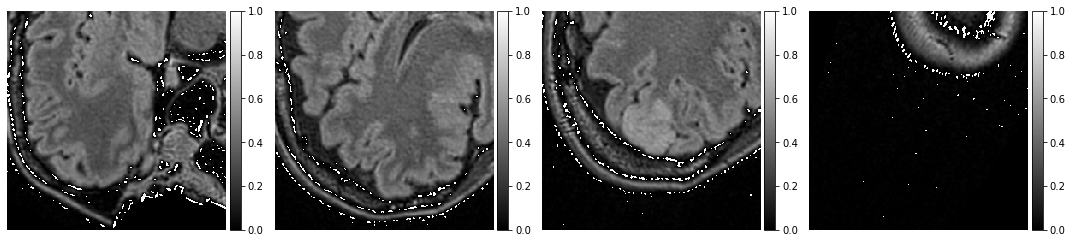

In [4]:
example_mri = [mri[0][1], mri[0][15], mri[0][20],mri[0][30]]
ne.plot.slices(example_mri, cmaps=['gray'], do_colorbars=True);

In [5]:
mri[0].shape

(32, 256, 256)

In [6]:
us[0].shape

(32, 256, 256)

In [7]:
all_data = us + mri
nb_bins = 16
bin_centers = np.linspace(all_data.min(), all_data.max(), nb_bins)
bin_centers

array([0.        , 0.10954248, 0.21908497, 0.32862745, 0.43816993,
       0.54771242, 0.6572549 , 0.76679739, 0.87633987, 0.98588235,
       1.09542484, 1.20496732, 1.3145098 , 1.42405229, 1.53359477,
       1.64313725])

In [8]:
vol_shape = (32, 256, 256)
nb_features = [
    [8, 16, 16, 16],
    [16, 16, 16, 16, 16, 8, 8]
]
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
losses = [vxm.losses.NMI(bin_centers, vol_size=vol_shape).loss, vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.5]

vxm info: mutual information loss is experimental


In [9]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights,  run_eagerly=True)

In [10]:
def vxm_data_generator(mri_data, us_data, batch_size=2):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = mri_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, mri_data.shape[0], size=batch_size)
        moving_images = mri_data[idx, ..., np.newaxis]
        fixed_images = us_data[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [11]:
# let's test generator
train_generator = vxm_data_generator(mri, us, batch_size=1)
in_sample, out_sample = next(train_generator)

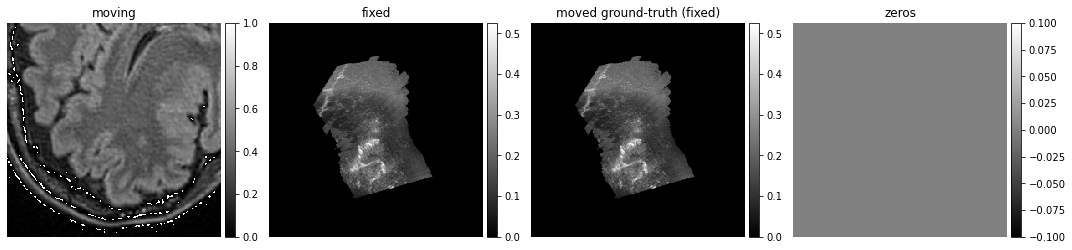

In [12]:
# visualize
images = [img[0, 15, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [13]:
del in_sample
del out_sample

In [16]:
nb_epochs = 2
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/2


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv3D]

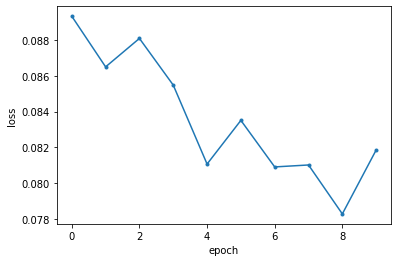

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [ ]:
# let's get some data
val_generator = vxm_data_generator(mri, us, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
val_pred = vxm_model.predict(val_input)

In [ ]:
%timeit vxm_model.predict(val_input)

1 loop, best of 3: 358 ms per loop


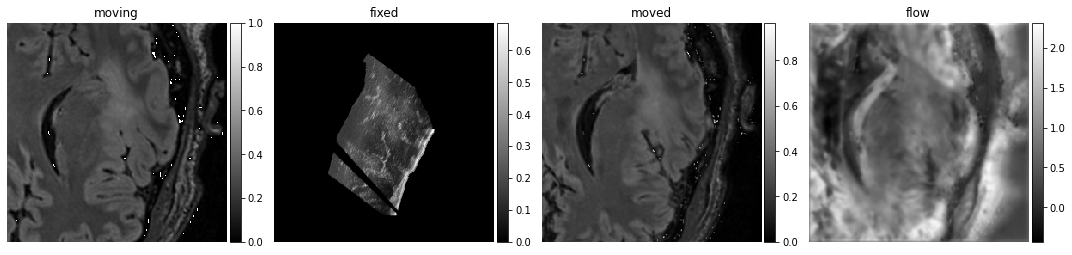

In [ ]:
images = [img[0,15, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);